In [122]:
import numpy as np
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
#%matplotlib notebook
from multiprocessing import Pool
from tqdm import tqdm
import time
#from pandarallel import pandarallel
model = load_model('i_predict CD_3Ddist2')

In [123]:
sc = StandardScaler()

In [124]:
df1_std = pd.read_csv('CD3D_100-150℃_0.2-1.6mm_0.4-0.9V_std', usecols=[1,2,3,4,5,6,7])

In [125]:
df_a = df1_std.head(30000)
df_a

,x座標,y座標,z座標,V[V],T_cell[℃],W_ch[mm],i[A/m^2]
0,-0.013693,0.615798,1.347558,-1.264911,-1.46385,-1.069045,1.269524
1,-0.013693,-0.823866,1.676388,-1.264911,-1.46385,-1.069045,1.314717
2,0.002954,-1.593271,1.676388,-1.264911,-1.46385,-1.069045,1.349897
3,-0.579714,0.949978,1.676388,-1.264911,-1.46385,-1.069045,1.157429
4,-1.079144,0.633220,1.265028,-1.264911,-1.46385,-1.069045,1.266472
...,...,...,...,...,...,...,...
29995,-0.146875,-1.394031,1.160576,-1.264911,-1.46385,-1.069045,1.308775
29996,0.219374,0.063056,1.301135,-1.264911,-1.46385,-1.069045,1.300899
29997,-0.762838,0.815356,1.418482,-1.264911,-1.46385,-1.069045,1.186059
29998,-0.846076,0.837529,1.676388,-1.264911,-1.46385,-1.069045,1.210851


In [126]:
df1 = pd.read_csv('CD3D_100-150℃_0.2-1.6mm_0.4-0.9V', usecols=[1,2,3,4,5,6,7])
df_c  = df1.head(30000)
df_c

,x座標,y座標,z座標,V[V],T_cell[℃],W_ch[mm],i[A/m^2]
0,0.000660,0.007235,0.000607,0.45,100.0,0.4,17071.141585
1,0.000660,0.002758,0.000650,0.45,100.0,0.4,17379.397333
2,0.000668,0.000365,0.000650,0.45,100.0,0.4,17619.354799
3,0.000388,0.008274,0.000650,0.45,100.0,0.4,16306.564360
4,0.000148,0.007289,0.000597,0.45,100.0,0.4,17050.327969
...,...,...,...,...,...,...,...
29995,0.000596,0.000985,0.000583,0.45,100.0,0.4,17338.871151
29996,0.000772,0.005516,0.000601,0.45,100.0,0.4,17285.146367
29997,0.000300,0.007855,0.000617,0.45,100.0,0.4,16501.846559
29998,0.000260,0.007924,0.000650,0.45,100.0,0.4,16670.947288


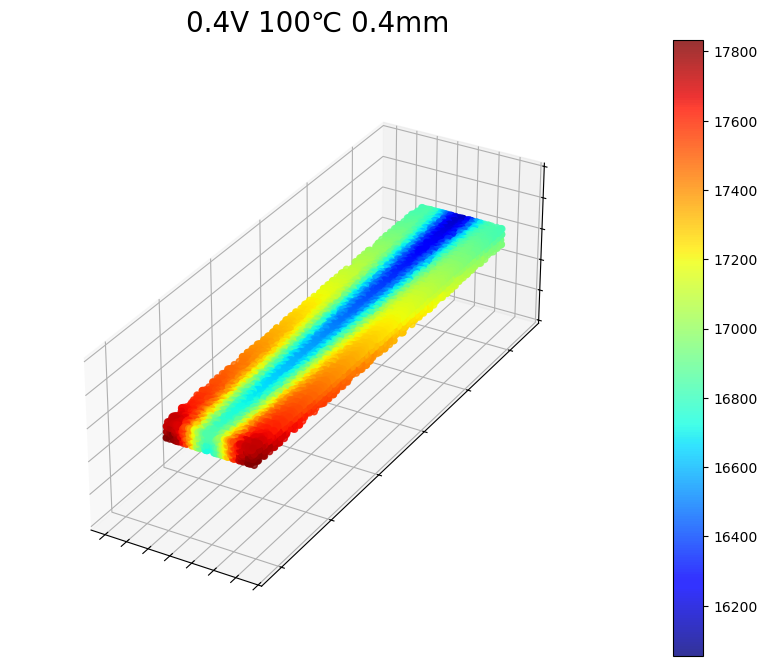

In [127]:
#COMSOLの結果の正規化されてないグラフ
fig2 = plt.figure(figsize=(12, 8))
ax2 = fig2.add_subplot(111, projection='3d')

sc2 = ax2.scatter(df_c['x座標'], df_c['y座標'],df_c['z座標'], c=df_c['i[A/m^2]'], cmap='jet', alpha=0.8)
plt.colorbar(sc2)

ax2.set_title("0.4V 100℃ 0.4mm", fontsize=20)
ax2.set_box_aspect((1,3,1))
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
ax2.axes.zaxis.set_ticklabels([])
ax2.set_box_aspect((1,3,1))

ax2.set_xlim(-0.0005,0.001)
#ax2.set_ylim(0,0.015)
ax2.set_zlim(0,0.001)

#plt.savefig('PEM_CD_COMSOL.png')
plt.show()

In [128]:
df_v = df1_std.loc[:,'V[V]']
v_mean = df_v.mean()
v_std = df_v.std()
print(v_mean)
print(v_std)

2.9796669434094394e-15
1.0000000841756842


In [129]:
#predictで正規化された出力求める→全てのパラメータを正規化から戻す
#v_a =   np.array(v)*v_std + v_mean 
#v_a

In [130]:
#説明変数Vの平均と標準偏差を出し、求めたいVの値を正規化する。
df_V = pd.DataFrame([0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9])
print(df_V.mean())
print(df_V.std())
V_pre = (0.4-df_V.mean())/df_V.std()
print("0.42Vの正規化された値：",V_pre)

0    0.65
dtype: float64
0    0.165831
dtype: float64
0.42Vの正規化された値： 0   -1.507557
dtype: float64


In [131]:
#説明変数Tの平均と標準偏差を出し、求めたいTの値を正規化する。
df_T = pd.DataFrame([100,110,120,130,140,150])
print(df_T.mean())
print(df_T.std())
T_pre = (100-df1["T_cell[℃]"].mean())/df1["T_cell[℃]"].std()
print("120℃の正規化された値：",T_pre)

0    125.0
dtype: float64
0    18.708287
dtype: float64
120℃の正規化された値： -1.4638499862030885


In [132]:
#説明変数Wの平均と標準偏差を出し、求めたいWの値を正規化する。
df_W = pd.DataFrame([0.4,0.8,1.6])
print(df_W.mean())
print(df_W.std())
W_pre = (0.4-df_W.mean())/df_W.std()
print("0.8mmの正規化された値：",W_pre)

0    0.933333
dtype: float64
0    0.61101
dtype: float64
0.8mmの正規化された値： 0   -0.872872
dtype: float64


In [133]:
#座標データを得る（正規化されてる）
df_pre = pd.read_csv('CD3D_100-150℃_0.2-1.6mm_0.4-0.9V_std', usecols=[1,2,3])
df_pre = df_pre.head(30000)
df_pre

,x座標,y座標,z座標
0,-0.013693,0.615798,1.347558
1,-0.013693,-0.823866,1.676388
2,0.002954,-1.593271,1.676388
3,-0.579714,0.949978,1.676388
4,-1.079144,0.633220,1.265028
...,...,...,...
29995,-0.146875,-1.394031,1.160576
29996,0.219374,0.063056,1.301135
29997,-0.762838,0.815356,1.418482
29998,-0.846076,0.837529,1.676388


In [134]:
#0.42V、120℃、0.8mmの電流密度分布を予測するための入力値
df_pre.insert(3, 'V[V]', -1.507557)
df_pre.insert(4,'T_cell[℃]',-1.336306)
df_pre.insert(5,'W_ch[mm]',-0.872872)
df_pre

,x座標,y座標,z座標,V[V],T_cell[℃],W_ch[mm]
0,-0.013693,0.615798,1.347558,-1.507557,-1.336306,-0.872872
1,-0.013693,-0.823866,1.676388,-1.507557,-1.336306,-0.872872
2,0.002954,-1.593271,1.676388,-1.507557,-1.336306,-0.872872
3,-0.579714,0.949978,1.676388,-1.507557,-1.336306,-0.872872
4,-1.079144,0.633220,1.265028,-1.507557,-1.336306,-0.872872
...,...,...,...,...,...,...
29995,-0.146875,-1.394031,1.160576,-1.507557,-1.336306,-0.872872
29996,0.219374,0.063056,1.301135,-1.507557,-1.336306,-0.872872
29997,-0.762838,0.815356,1.418482,-1.507557,-1.336306,-0.872872
29998,-0.846076,0.837529,1.676388,-1.507557,-1.336306,-0.872872


In [135]:
#i[A/mm^2]を学習したモデルで予測
df_i_pre = pd.DataFrame(model.predict(df_pre), columns = ['i[A/m^2]'])
df_i_pre

938/938 [==============================] - 1s 883us/step


,i[A/m^2]
0,18563.763672
1,18995.699219
2,19380.144531
3,18437.855469
4,19177.521484
...,...
29995,19057.660156
29996,19072.722656
29997,18717.777344
29998,18811.357422


In [136]:
#グラフ化のため、データフレームにする
df = pd.concat([df_pre, df_i_pre], axis=1)
df_b = df.head(30000)
df_b

,x座標,y座標,z座標,V[V],T_cell[℃],W_ch[mm],i[A/m^2]
0,-0.013693,0.615798,1.347558,-1.507557,-1.336306,-0.872872,18563.763672
1,-0.013693,-0.823866,1.676388,-1.507557,-1.336306,-0.872872,18995.699219
2,0.002954,-1.593271,1.676388,-1.507557,-1.336306,-0.872872,19380.144531
3,-0.579714,0.949978,1.676388,-1.507557,-1.336306,-0.872872,18437.855469
4,-1.079144,0.633220,1.265028,-1.507557,-1.336306,-0.872872,19177.521484
...,...,...,...,...,...,...,...
29995,-0.146875,-1.394031,1.160576,-1.507557,-1.336306,-0.872872,19057.660156
29996,0.219374,0.063056,1.301135,-1.507557,-1.336306,-0.872872,19072.722656
29997,-0.762838,0.815356,1.418482,-1.507557,-1.336306,-0.872872,18717.777344
29998,-0.846076,0.837529,1.676388,-1.507557,-1.336306,-0.872872,18811.357422


In [171]:
df_i = pd.read_csv('CD3D_100-150℃_0.2-1.6mm_0.4-0.9V', usecols=[7]).head(30000)

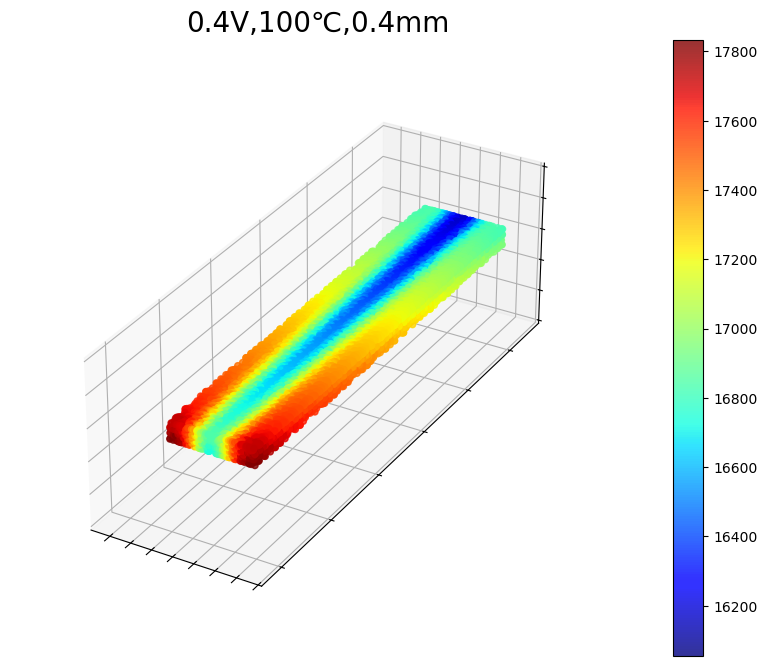

In [172]:
fig4 = plt.figure(figsize=(12, 8))
ax4 = fig4.add_subplot(111, projection='3d')

sc4 = ax4.scatter(df_c['x座標'], df_c['y座標'], df_c['z座標'],c=df_i['i[A/m^2]'], cmap='jet', alpha=0.8)
#plt.colorbar(sc4, ax=ax4, shrink=0.75) #colorbarのサイズを縦横0.5倍にする。)
plt.colorbar(sc4)

ax4.set_title("0.4V,100℃,0.4mm", fontsize=20)
#ax4.set_xlabel('$x$', fontsize=15)
#ax4.set_ylabel('$y$', fontsize=15)
#ax4.set_zlabel('$z$', fontsize=15)
ax4.set_box_aspect((1,3,1))
ax4.axes.xaxis.set_ticklabels([])
ax4.axes.yaxis.set_ticklabels([])
ax4.axes.zaxis.set_ticklabels([])

ax4.set_xlim(-0.00055,0.001)
ax4.set_zlim(0,0.001)
plt.savefig('PEM_CD_Predict_0.42V.png')
plt.show()

In [139]:
#指定した変数の電流密度分布予測を求める
def I_pre0(V,T,W):
 eps = 10**(-6)

 global df1, df1_std
 df2_std = df1_std[(Vstd(0.4)-eps < df1_std['V[V]']) &  ( df1_std['V[V]'] < Vstd(0.4)+eps )
                   & (Tstd(100)-eps < df1_std['T_cell[℃]']) & (df1_std['T_cell[℃]'] < Tstd(100)+eps)
                   & (Wstd(W)-eps < df1_std['W_ch[mm]']) & (df1_std['W_ch[mm]'] < Wstd(W)+eps)]                   #流路幅を固定して座標を抽出
 df3_std = df2_std.drop(['V[V]', 'T_cell[℃]','W_ch[mm]','i[A/m^2]'], axis=1)
 df2_std2 = pd.DataFrame({'V[V]':[Vstd(V)]*30000,'T_cell[℃]':[Tstd(T)]*30000,'W_ch[mm]':[Wstd(0.8)]*30000}, index=df2_std.index)
 df3_std2 = pd.concat([df3_std,df2_std2], axis=1)
 df4_std = model.predict(df3_std2)    #モデルで予測
 df_iPRE1 = pd.DataFrame(df4_std)
 #df_iPRE1 =df4_std.apply(i_restd)   #予測値の標準化を戻す。（データフレームに関数を適用）
 df_iPRE2 = df_iPRE1.rename(columns={0:'i[A/m^2]'})
 df_iPRE2 = df_iPRE2.set_index(df2_std.index)
 df_iPRE = pd.concat([df3_std2,df_iPRE2], axis = 1)
 df_iPRE

 return df_iPRE

In [168]:
def I_pre(V,T,W):
  df_iPRE = I_pre0(V,T,W)
  df_d = df1[(df1['V[V]']==0.4) & (df1['T_cell[℃]']==100) & (df1['W_ch[mm]']==W)]  #流路幅の値だけ変えればよい

  fig5 = plt.figure(figsize=(12, 8))
  ax5 = fig5.add_subplot(111, projection='3d')

  sc5 = ax5.scatter(df_d['x座標'], df_d['y座標'], df_d['z座標'],c=df_iPRE['i[A/m^2]'],  cmap='jet', alpha=0.8)
  plt.colorbar(sc5)

  ax5.set_title([V,"V,",T,"℃,",W,"mm"], fontsize=20)
  ax5.set_box_aspect((1,3,1))
  ax5.axes.xaxis.set_ticklabels([])
  ax5.axes.yaxis.set_ticklabels([])
  ax5.axes.zaxis.set_ticklabels([])

  ax5.set_xlim(-0.0005,0.001)
  ax5.set_zlim(0,0.002)
  #plt.savefig('PEM_CD_Predict_0.42V.png')
  plt.show()

938/938 [==============================] - 1s 1ms/step


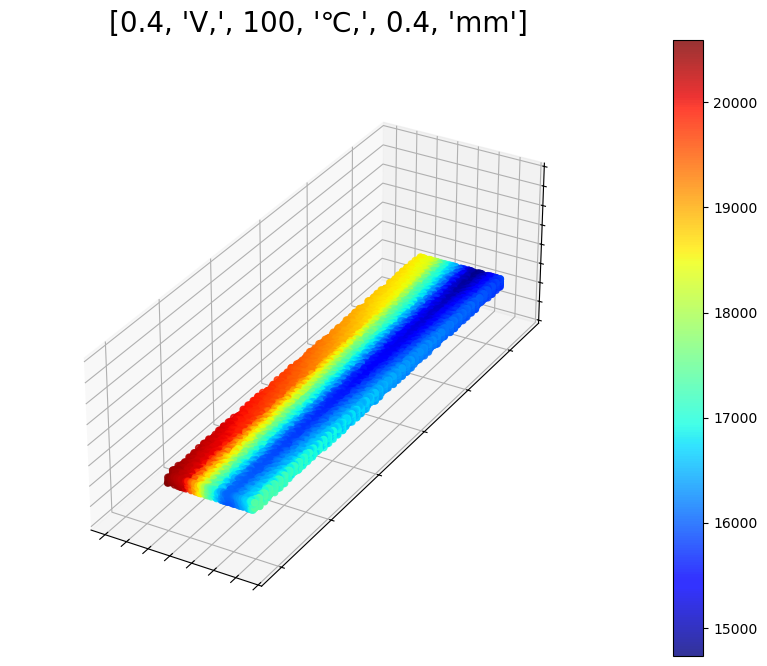

計算にかかった時間: 2.882388114929199秒


In [169]:
start_time = time.time()
I_pre(0.4,100,0.4)
end_time = time.time()
elapsed_time = end_time - start_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

938/938 [==============================] - 1s 884us/step


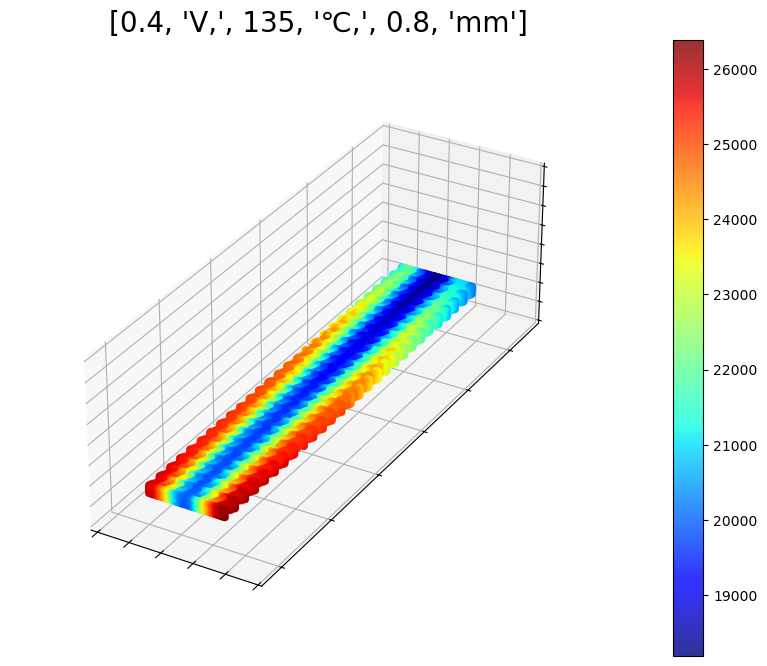

In [142]:
I_pre(0.4,135,0.8)

In [143]:
def i_COM(V,T,W):  #COMSOLの結果を表示する関数
  global df1
  df_A = df1[(df1['V[V]']==V) & (df1['T_cell[℃]']==T) & (df1['W_ch[mm]']==W)]
  #COMSOLの結果の正規化されてないグラフ
  fig2 = plt.figure(figsize=(12, 8))
  ax2 = fig2.add_subplot(111, projection='3d')

  sc2 = ax2.scatter(df_A['x座標'], df_A['y座標'],df_A['z座標'], c=df_A['i[A/m^2]'], cmap='jet', alpha=0.8)
  plt.colorbar(sc2)

  ax2.set_title(["COMSOL",V,"V,",T,"℃,",W,"mm"], fontsize=20)
  ax2.set_box_aspect((1,3,1))
  ax2.axes.xaxis.set_ticklabels([])
  ax2.axes.yaxis.set_ticklabels([])
  ax2.axes.zaxis.set_ticklabels([])
  ax2.set_box_aspect((1,3,1))

  ax2.set_xlim(-0.0005,0.001)
  #ax2.set_ylim(0,0.015)
  ax2.set_zlim(0,0.001)

  #plt.savefig('PEM_CD_COMSOL.png')
  plt.show()
  

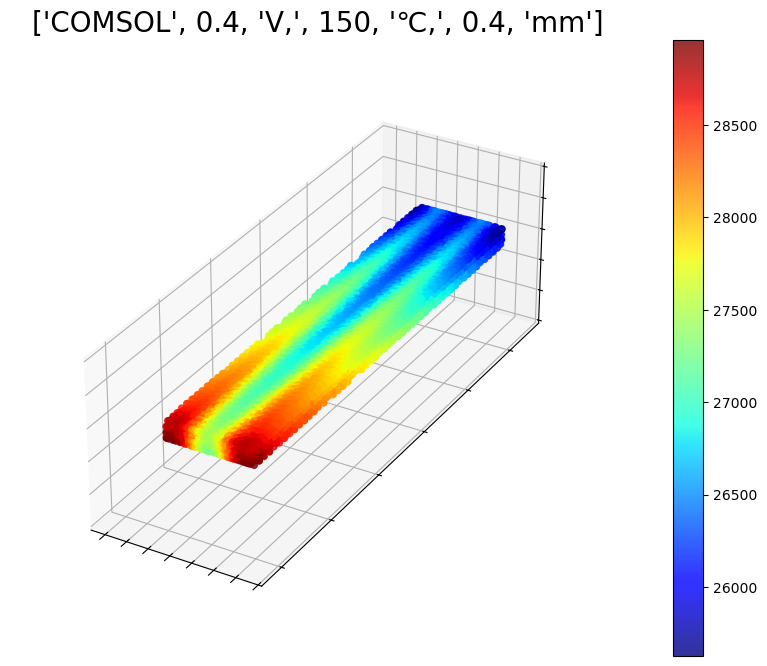

In [144]:
i_COM(0.4,150,0.4)

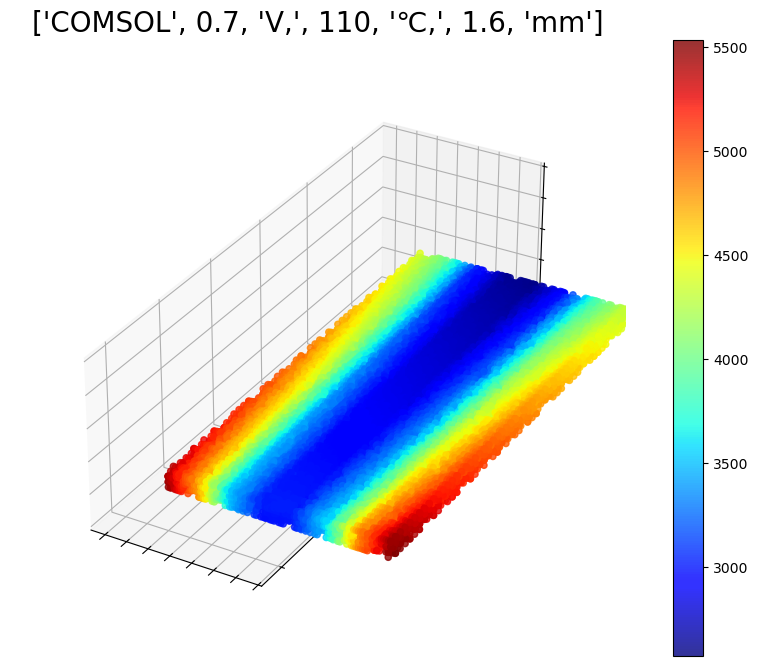

In [175]:
i_COM(0.7,110,1.6)

938/938 [==============================] - 1s 884us/step


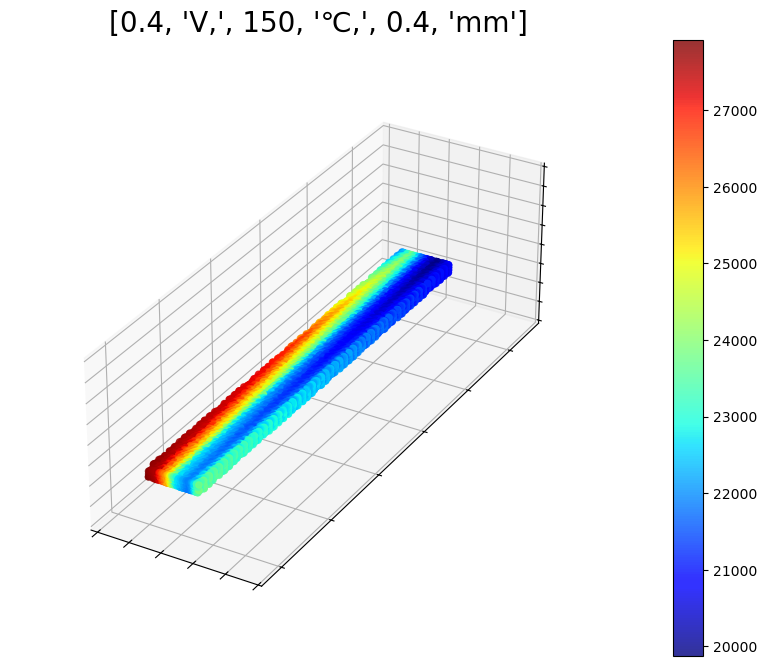

In [146]:
I_pre(0.4,150,0.4)

In [147]:
#COMSOLの結果の電流密度の平均を求める関数
def I_ave(V,T,W):
    global df1
    dfA = df1[(df1['V']==0.4) & (df1['T']==100)&(df1['W']==0.4)]
    dfB = dfA.replace({'V': {0.4: V}}).replace({'T': {100: T}}).replace({'W': {0.4: W}})
    dfC = model.predict(dfB.iloc[:,1:7])
    dfD = dfC.mean()
    print(dfD)

In [148]:
#COMSOLの電流密度の平均表示
dfCOM = pd.DataFrame(columns=['V[V]','T_cell[℃]','W_ch[mm]','i_ave[A/m^2]'])

def I_aveCOM(V,T,W):
  global df1
  df_iaveCOM1= df1[(df1['V[V]']==V) & (df1['T_cell[℃]']==T)&(df1['W_ch[mm]']==W)]
  df_iaveCOM2 = df_iaveCOM1['i[A/m^2]'].mean()
  return (df_iaveCOM2)

for V in [0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]:
  for T in [100,110,120,130,140,150]:
        for W in [0.4,0.8,1.6]:
          i_ave = I_aveCOM(V,T,W)
          new_row = {'V[V]':V,'T_cell[℃]':T,'W_ch[mm]':W,'i_ave[A/m^2]':i_ave}
          dfCOM = pd.concat([dfCOM, pd.DataFrame([new_row])], ignore_index=True)
dfCOM

C:\Users\user\AppData\Local\Temp\ipykernel_13320\1827688777.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfCOM = pd.concat([dfCOM, pd.DataFrame([new_row])], ignore_index=True)


,V[V],T_cell[℃],W_ch[mm],i_ave[A/m^2]
0,0.4,100,0.4,19911.302770
1,0.4,100,0.8,17630.834758
2,0.4,100,1.6,8034.126096
3,0.4,110,0.4,21397.446575
4,0.4,110,0.8,18892.178701
...,...,...,...,...
193,0.9,140,0.8,1399.599533
194,0.9,140,1.6,1188.764448
195,0.9,150,0.4,2148.175113
196,0.9,150,0.8,2034.002094


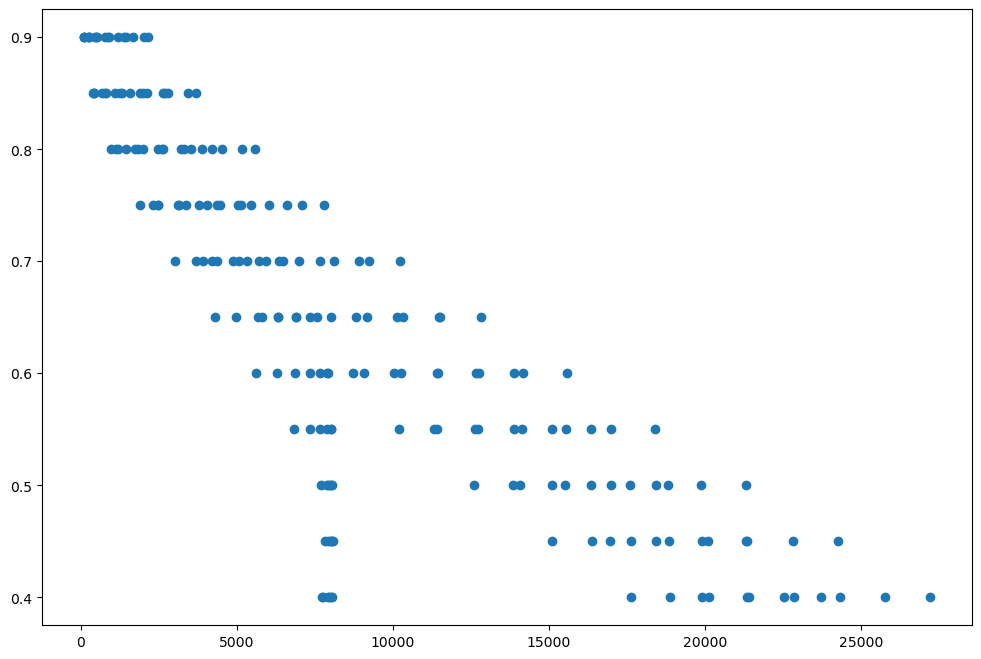

In [149]:
figCOM = plt.figure(figsize=(12, 8))

axCOM = figCOM.add_subplot(111)
scCOM = axCOM.scatter(dfCOM['i_ave[A/m^2]'],dfCOM['V[V]'])

plt.show()

In [150]:
def Vstd(V):
 #説明変数Vの平均と標準偏差を出し、求めたいVの値を正規化する。
 global df1
 df_V = pd.DataFrame([0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9])
 V_std = (V-df1["V[V]"].mean())/df1["V[V]"].std()
 return(V_std)

def Tstd(T):
  #説明変数Tの平均と標準偏差を出し、求めたいTの値を正規化する。
 global df1
 df_T = pd.DataFrame([100,110,120,130,140,150])
 T_std = (T-df1["T_cell[℃]"].mean())/df1["T_cell[℃]"].std()
 return(T_std) 

def Wstd(W):
 #説明変数Wの平均と標準偏差を出し、求めたいWの値を正規化する。
 global df1
 df_W = pd.DataFrame([0.4,0.8,1.6])
 W_std = (W-df1["W_ch[mm]"].mean())/df1["W_ch[mm]"].std()
 return(W_std)

def i_restd(i): 
 global df1
 i_restd = (i*df1["i[A/m^2]"].std() + df1["i[A/m^2]"].mean() )
 return(i_restd)

In [151]:
i_restd(-0.778)

3105.3587682120387

In [152]:
def I_ave_pre(T,W):
 dfPRE = pd.DataFrame(columns=['V[V]','i_ave[A/m^2]'])
 
 global df1, df1_std
 df2_std = df1_std[['x座標','y座標','z座標']].head(30000) #これは0.4mmにしか使えない
 df3_std = pd.DataFrame({'T_cell[℃]':[Tstd(T)]*30000,'W_ch[mm]':[Wstd(W)]*30000})
 df4_std = pd.concat([df2_std,df3_std], axis=1)
 for V in np.linspace(0.4,0.9,100):   #Vの連続値に対応した電流密度を出す
    df5_std = pd.DataFrame({'V[V]':[Vstd(V)]*30000})
    df6_std = pd.concat([df4_std.iloc[:, :3],df5_std,df4_std.iloc[:,3:]], axis=1)
    df7_std = model.predict(df6_std)    #モデルで予測
    df7_std = pd.DataFrame(df7_std)
    df7 = df7_std.apply(i_restd) #予測値の標準化を戻す。（データフレームに関数を適用）
    i_ave_pre = df7_std.mean()        #平均値を返す
    new_row = {'V[V]':V,'i_ave[A/m^2]':i_ave_pre}
    dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力
 
 return dfPRE

 57/938 [>.............................] - ETA: 0s 

C:\Users\user\AppData\Local\Temp\ipykernel_13320\2159109868.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


938/938 [==============================] - 1s 1ms/step


c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


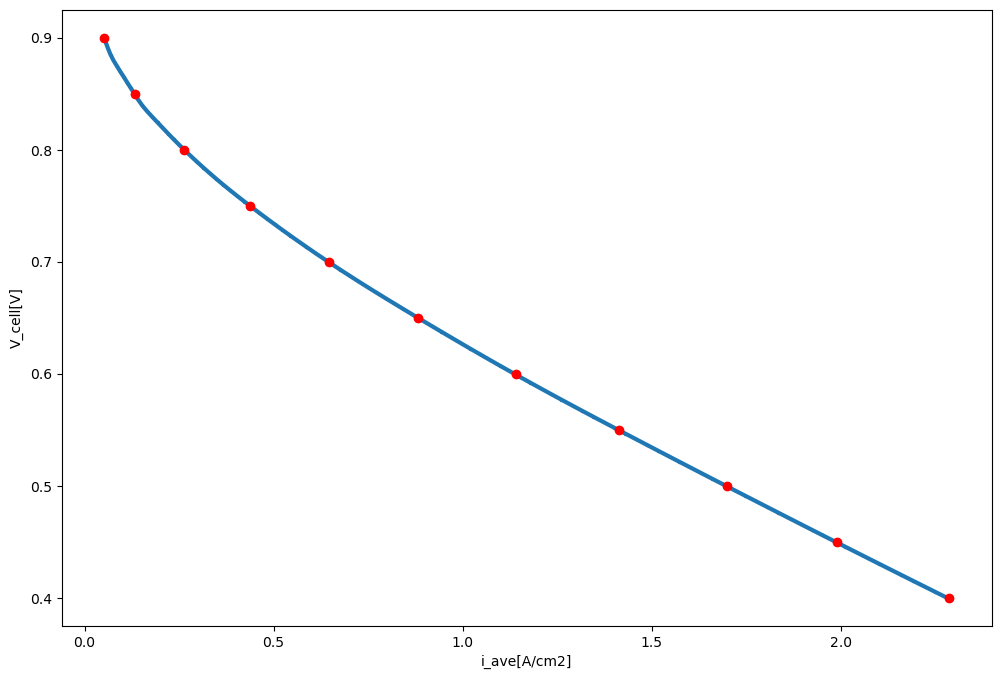

計算にかかった時間: -11.234259605407715秒


In [153]:
start_time = time.time()

#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(120,0.4)
figPRE = plt.figure(figsize=(12, 8))
axPRE = figPRE.add_subplot(111)

#CONSOL結果の表示
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==120)&(dfCOM["W_ch[mm]"]==0.4)]
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]']*1e-4,dfCOM0['V[V]'],color='red')

scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]']*1e-4,dfPRE['V[V]'],s=2,zorder=0)
axPRE.plot(dfPRE['i_ave[A/m^2]']*1e-4, dfPRE['V[V]'], linestyle='-', linewidth=3, zorder=0) 

# 軸ラベルを追加
plt.xlabel('i_ave[A/cm2]')
plt.ylabel('V_cell[V]')

plt.show()
elapsed_time = end_time - start_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

117/938 [==>...........................] - ETA: 0s

C:\Users\user\AppData\Local\Temp\ipykernel_13320\2159109868.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


938/938 [==============================] - 1s 750us/step


c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


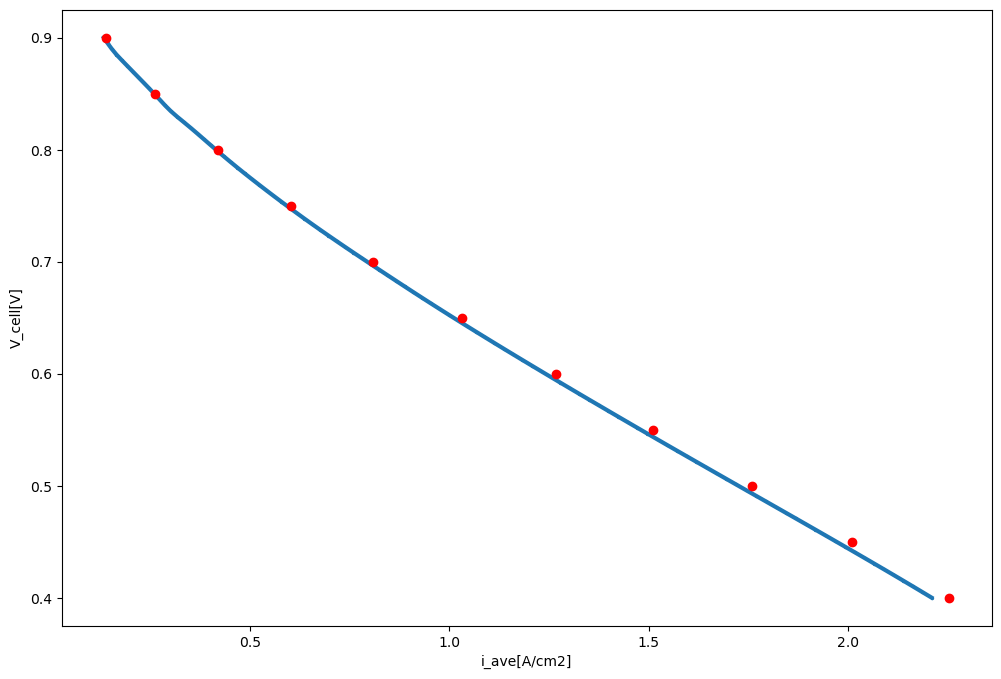

計算にかかった時間: 112.67022728919983秒


In [154]:
start_time = time.time()

#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(140,0.8)
figPRE = plt.figure(figsize=(12, 8))
axPRE = figPRE.add_subplot(111)

#CONSOL結果の表示
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==140)&(dfCOM["W_ch[mm]"]==0.8)]
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]']*1e-4,dfCOM0['V[V]'],color='red')

scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]']*1e-4,dfPRE['V[V]'],s=2,zorder=0)
axPRE.plot(dfPRE['i_ave[A/m^2]']*1e-4, dfPRE['V[V]'], linestyle='-', linewidth=3, zorder=0) 

# 軸ラベルを追加
plt.xlabel('i_ave[A/cm2]')
plt.ylabel('V_cell[V]')

plt.show()
elapsed_time = start_time - end_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

 55/938 [>.............................] - ETA: 1s 

C:\Users\user\AppData\Local\Temp\ipykernel_13320\2159109868.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


938/938 [==============================] - 1s 741us/step


c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


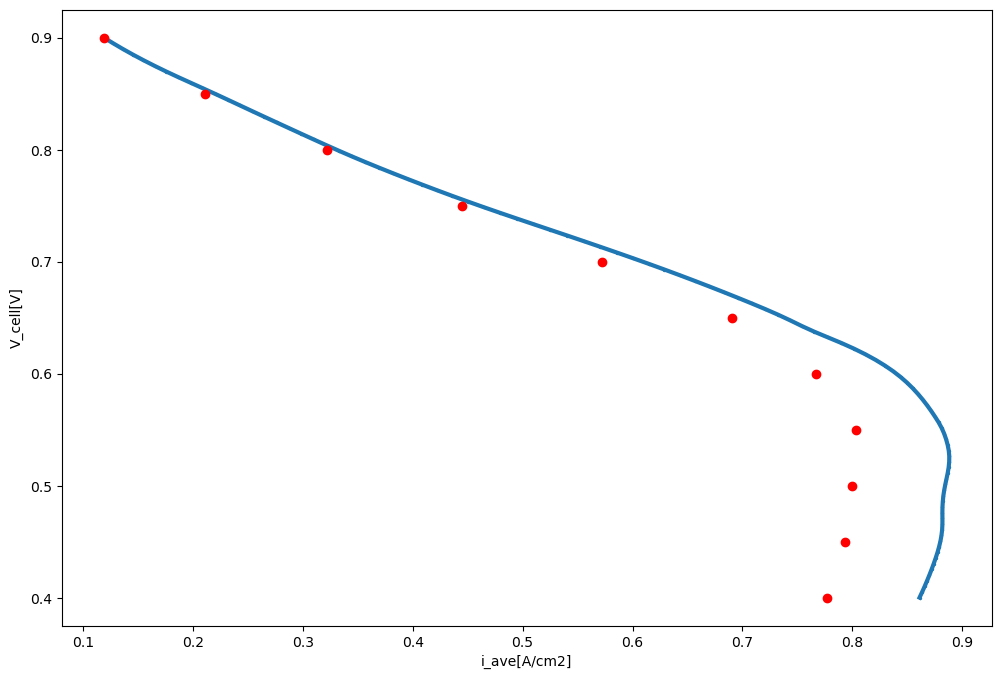

計算にかかった時間: 209.15293383598328秒


In [155]:
start_time = time.time()

#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(140,1.6)
figPRE = plt.figure(figsize=(12, 8))
axPRE = figPRE.add_subplot(111)

#CONSOL結果の表示
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==140)&(dfCOM["W_ch[mm]"]==1.6)]
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]']*1e-4,dfCOM0['V[V]'],color='red')

scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]']*1e-4,dfPRE['V[V]'],s=2,zorder=0)
axPRE.plot(dfPRE['i_ave[A/m^2]']*1e-4, dfPRE['V[V]'], linestyle='-', linewidth=3, zorder=0) 

# 軸ラベルを追加
plt.xlabel('i_ave[A/cm2]')
plt.ylabel('V_cell[V]')

plt.show()
elapsed_time = start_time - end_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

 59/938 [>.............................] - ETA: 0s 

C:\Users\user\AppData\Local\Temp\ipykernel_13320\2159109868.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


938/938 [==============================] - 1s 767us/step


c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


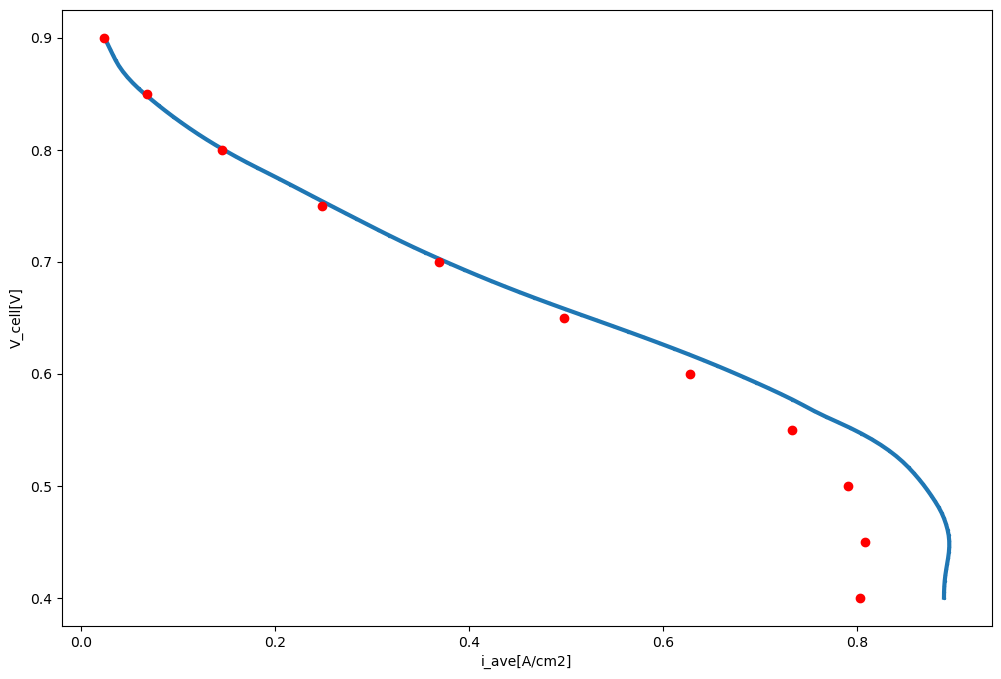

計算にかかった時間: 310.77681279182434秒


In [156]:
start_time = time.time()

#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(110,1.6)
figPRE = plt.figure(figsize=(12, 8))
axPRE = figPRE.add_subplot(111)

#CONSOL結果の表示
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==110)&(dfCOM["W_ch[mm]"]==1.6)]
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]']*1e-4,dfCOM0['V[V]'],color='red')

scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]']*1e-4,dfPRE['V[V]'],s=2,zorder=0)
axPRE.plot(dfPRE['i_ave[A/m^2]']*1e-4, dfPRE['V[V]'], linestyle='-', linewidth=3, zorder=0) 

# 軸ラベルを追加
plt.xlabel('i_ave[A/cm2]')
plt.ylabel('V_cell[V]')

plt.show()
elapsed_time = start_time - end_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

 66/938 [=>............................] - ETA: 0s 

C:\Users\user\AppData\Local\Temp\ipykernel_13320\2159109868.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


938/938 [==============================] - 1s 777us/step


c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


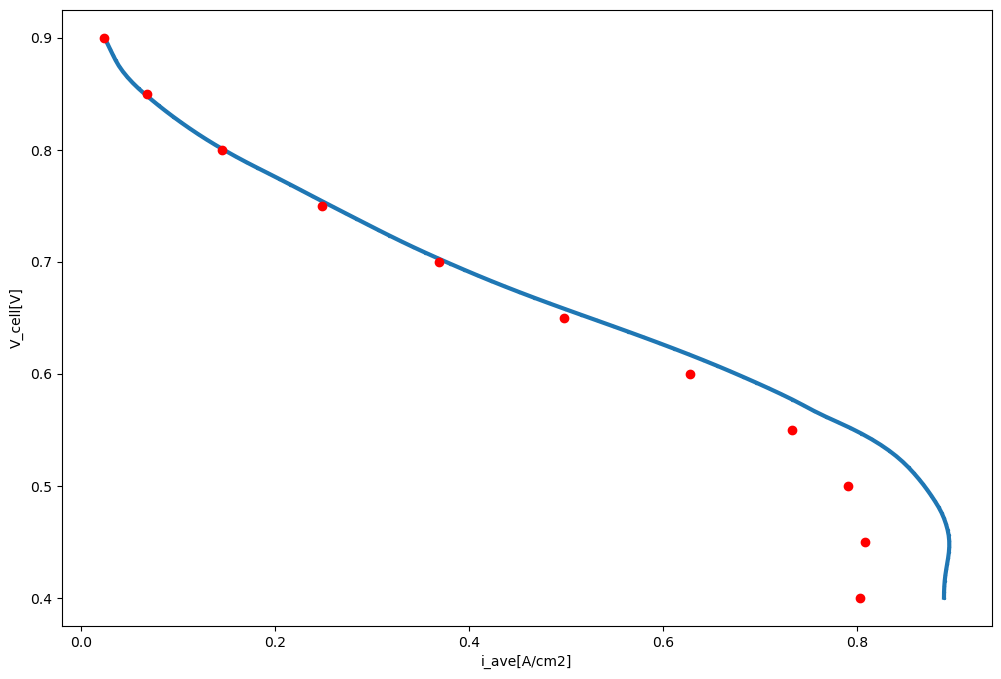

計算にかかった時間: 409.8223533630371秒


In [157]:
start_time = time.time()

#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(110,1.6)
figPRE = plt.figure(figsize=(12, 8))
axPRE = figPRE.add_subplot(111)

#CONSOL結果の表示
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==110)&(dfCOM["W_ch[mm]"]==1.6)]
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]']*1e-4,dfCOM0['V[V]'],color='red')

scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]']*1e-4,dfPRE['V[V]'],s=2,zorder=0)
axPRE.plot(dfPRE['i_ave[A/m^2]']*1e-4, dfPRE['V[V]'], linestyle='-', linewidth=3, zorder=0) 

# 軸ラベルを追加
plt.xlabel('i_ave[A/cm2]')
plt.ylabel('V_cell[V]')

plt.show()
elapsed_time = start_time - end_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

 53/938 [>.............................] - ETA: 1s 

C:\Users\user\AppData\Local\Temp\ipykernel_13320\2159109868.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


938/938 [==============================] - 2s 2ms/step


c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\user\anaconda3\envs\OKA\lib\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


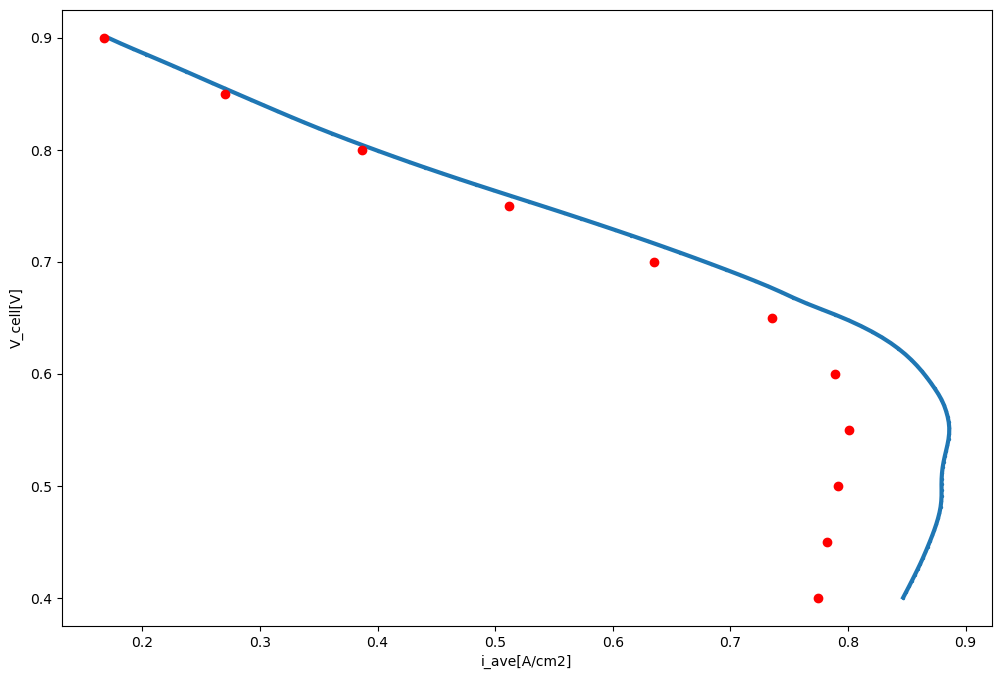

計算にかかった時間: 513.204395532608秒


In [158]:
start_time = time.time()

#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(150,1.6)
figPRE = plt.figure(figsize=(12, 8))
axPRE = figPRE.add_subplot(111)

#CONSOL結果の表示
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==150)&(dfCOM["W_ch[mm]"]==1.6)]
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]']*1e-4,dfCOM0['V[V]'],color='red')

scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]']*1e-4,dfPRE['V[V]'],s=2,zorder=0)
axPRE.plot(dfPRE['i_ave[A/m^2]']*1e-4, dfPRE['V[V]'], linestyle='-', linewidth=3, zorder=0) 

# 軸ラベルを追加
plt.xlabel('i_ave[A/cm2]')
plt.ylabel('V_cell[V]')

plt.show()
elapsed_time = start_time - end_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

In [159]:
import tensorflow as tf
# MAPEを計算する関数を定義
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10  # ゼロで割ることを避けるための小さな値
    percentage_error = tf.abs((y_true - y_pred) / tf.abs(y_true))
    mape = tf.reduce_mean(percentage_error) * 100.0
    return mape

In [160]:
df7 = model.predict(df1_std.drop(['i[A/m^2]'], axis=1)) 

185625/185625 [==============================] - 225s 1ms/step


In [161]:
# MAPEを計算
df7 = pd.DataFrame(df7)
df8 = pd.concat([pd.DataFrame(df1['i[A/m^2]']),df7], axis=1)
#df9 = df8.sample(n=360000)
y_true = tf.constant(df8.iloc[:, 0].values, dtype=tf.float32)
y_pred = tf.constant(df8.iloc[:, 1].values, dtype=tf.float32)
mape_value = mean_absolute_percentage_error(y_true,y_pred)

# 結果を表示
print(f"MAPE:{mape_value.numpy()}%")

MAPE:2.3516311645507812%


In [162]:
pd.DataFrame(y_pred-y_true).max()

0    3985.005615
dtype: float32

In [163]:
pd.DataFrame(y_pred-y_true).idxmax()

0    1777328
dtype: int64

In [164]:
df8

,i[A/m^2],0
0,17071.141585,17045.109375
1,17379.397333,17406.919922
2,17619.354799,17508.644531
3,16306.564360,16267.607422
4,17050.327969,16930.894531
...,...,...
5939995,1365.372580,1425.918701
5939996,1669.323163,1528.809814
5939997,1575.933570,1471.042969
5939998,1538.052593,1532.669922


In [165]:
df1.iloc[1778067]

x座標             0.000590
y座標             0.000197
z座標             0.000286
V[V]            0.650000
T_cell[℃]     110.000000
W_ch[mm]        1.600000
i[A/m^2]     7035.001819
Name: 1778067, dtype: float64

In [166]:
df8.iloc[1778067]

i[A/m^2]    7035.001819
0           5099.385742
Name: 1778067, dtype: float64

In [167]:
tf.keras.metrics.mean_squared_error(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=32362.283>